<a href="https://colab.research.google.com/github/Alecia113/self-directed-exercises-python-/blob/main/KNN%2BNB%2BLR_checkpoint(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Qestions: 
1. parameter tuning 
2. class programming 
3. Accuracy & dimension reduction 
4. optimization 
5. output file 
6. confusion matrix 



## 1. Loading data and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/COMP5318/Assignment 1
!pwd

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/My Drive/COMP5318/Assignment 1'
/content
/content


In [ ]:
# importing necessary libraries 
import h5py 
import numpy as np 
import scipy 
import matplotlib.pyplot as plt
import pandas as pd 
import math

from tqdm import tqdm 
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# load training and test data with corresponding labels
with h5py.File('/content/drive/My Drive/5318a1/Assignment/Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('/content/drive/My Drive/5318a1/Assignment/Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
with h5py.File('/content/drive/My Drive/5318a1/Assignment/Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('/content/drive/My Drive/5318a1/Assignment/Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

OSError: ignored

## 2. Initial Data Analysis

In [ ]:
# check dataset size 
# 30k pictures, 784 pixels for each picture
data_train.shape

(30000, 784)

In [ ]:
# 3000 test label were hidden
data_test.shape
label_test.shape

(2000,)

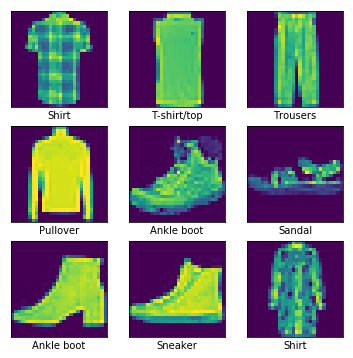

In [ ]:
# demo example
# printing out the first 9 pictures with their corresponding classes 
# https://github.com/radenjezic153/Stat_ML/blob/master/project.ipynb
label_names = ['T-shirt/top','Trousers','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i].reshape(28, 28))
    plt.xlabel(label_names[label_train[i]])
plt.show()

In [ ]:
# check the distribution for each class
label_names = ['T-shirt/top','Trousers','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] 
print("Train Labels count: \n")
for i in range(10):
  print ('Class ' + str(i) + ' -- ' + label_names[i] + ': ' + str(len([j for j in label_train if j==i])))

print("\n Test Labels count: \n")
for i in range(10):
  print ('Class ' + str(i) + ' -- ' + label_names[i] + ': ' + str(len([j for j in label_test if j==i])))

# the classes for both the training set and the test set is roughly equally distributed 
# prediction accuracy would make sense 

Train Labels count: 

Class 0 -- T-shirt/top: 3041
Class 1 -- Trousers: 2972
Class 2 -- Pullover: 2936
Class 3 -- Dress: 3008
Class 4 -- Coat: 2954
Class 5 -- Sandal: 3029
Class 6 -- Shirt: 3023
Class 7 -- Sneaker: 3013
Class 8 -- Bag: 3040
Class 9 -- Ankle boot: 2984

 Test Labels count: 

Class 0 -- T-shirt/top: 192
Class 1 -- Trousers: 184
Class 2 -- Pullover: 206
Class 3 -- Dress: 207
Class 4 -- Coat: 220
Class 5 -- Sandal: 190
Class 6 -- Shirt: 190
Class 7 -- Sneaker: 192
Class 8 -- Bag: 227
Class 9 -- Ankle boot: 192


## 3. Data Preparation and Data Pre-processing

### 3.1 Normalisation
- the data has been normalised and converted from 2-D array (28 * 28) into 1-D array (784 * 1) 

In [ ]:
data_train[0].shape

(784,)

In [ ]:
data_train[10]
# the data has been normalised with the range [0, 1]
# original pixel: grey scale : 0 - 255

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.25882354, 0.78823537, 0.8862746 , 0.87843144, 0.8235295 ,
       0.82745105, 0.9058824 , 0.882353  , 0.5764706 , 0.00784314,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.62352943, 0.8235295 , 0.97647065,
       0.91372555, 0.9058824 , 0.90196085, 0.8941177 , 0.9176471 ,
       0.9294118 , 0.9921569 , 0.78823537, 0.48627454, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.43137258, 0.7137255 , 0.93725497, 0.9215687 , 0.9294118 ,
       0.8588236 , 0.854902  , 0.9176471 , 0.9333334 , 0.91372

### 3.2 SVD

In [ ]:
# SVD for Training data and test data
# https://stackoverflow.com/questions/24913232/using-numpy-np-linalg-svd-for-singular-value-decomposition
# https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
def svd (original_data, n):
  # n, m = original_data.shape
  U, s, Vt = np.linalg.svd(original_data, full_matrices = False)
  S = np.diag(s) 
  restruct_data = U[:, 0:n].dot(S[0:n, 0:n]).dot(Vt[0:n, :])
  
  return restruct_data
                          

In [ ]:
# checking the similarities of original data and restructured data 
# the matrix constructed by the first 10 singular values are almost the same as the original
X_svd = svd(data_train[0].reshape(28, 28), 10)
X_original = data_train[0].reshape(28, 28)
print(np.std(X_svd)/ np.std(X_original) * 100 , '%')

99.81694221496582 %


- SVD can only be apolied for individual datapoint, while PCA can be applied to the entire dataset 

### 3.3 PCA


In [ ]:
# https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
# https://zhuanlan.zhihu.com/p/85701151
  
def pca (original_data, n): 
  # centralise the original data 
  adjusted_data = original_data - np.mean(original_data, axis = 0) 
  # Compute covariance matrix
  Cov = np.cov(adjusted_data.T)
  # Eigen decomposition
  eigen_vals, eigen_vecs = np.linalg.eig(Cov)
  # sort the eigenvalues and eigenvectors by descending order
  L = -np.sort(-eigen_vals)[:n]  
  V = eigen_vecs[:,np.argsort(-eigen_vals)][:,:n] 
  # reconstruct the data matrix by projection
  data_pca = np.dot(adjusted_data, V) 

  return data_pca

In [ ]:
# checking the shape
reconData = pca(data_train, 15)
reconData.shape

(30000, 15)

In [ ]:
reconData[0]

array([-1.66347483, -3.47519027, -0.20321187,  0.27596957,  0.94181983,
        1.30186123,  0.39780129, -0.14494958,  1.43218149, -0.76182912,
        0.69717579,  1.57683819,  0.02252224,  0.24436926,  0.45004494])

In [ ]:
# Calculating the explained variance on each of components
# https://wendynavarrete.com/principal-component-analysis-with-numpy/

def var_explained_pca (original_data):
  # same steps as the above
  var_explained = []
  adjusted_data = original_data - np.mean(original_data, axis = 0) 
  Cov = np.cov(adjusted_data.T)
  eigen_vals, eigen_vecs = np.linalg.eig(Cov)
  
  for i in eigen_vals: 
    var_explained.append((i/sum(eigen_vals))*100)
  
  return var_explained

In [ ]:
# find the proper number of components to keep for further analysis
var_explained = var_explained_pca(data_train)
# print(var_explained)
cum_var_explained = np.cumsum(var_explained)
print(np.round(cum_var_explained[0:50], 3))
# the first 50 components have explained 86.2% of the total information
# the remaining 734 could be safely ignored

[29.077 46.806 52.82  57.757 61.585 65.035 67.395 69.271 70.627 71.937
 72.923 73.834 74.601 75.259 75.867 76.456 77.012 77.543 78.004 78.461
 78.892 79.297 79.682 80.054 80.418 80.771 81.105 81.425 81.734 82.025
 82.303 82.571 82.834 83.089 83.337 83.573 83.803 84.028 84.248 84.459
 84.66  84.856 85.049 85.232 85.406 85.578 85.746 85.912 86.073 86.229]


Text(0, 0.5, 'Cumulative explained variance')

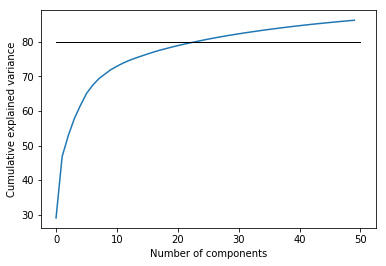

In [ ]:
# visualisation for report 
import seaborn as sns
sns.lineplot(x = range(0, 50), y = cum_var_explained[0:50])
plt.plot([0,50], [80,80], 'k-', lw = 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

In [ ]:
# dimension reduction by PCA for both the training set and the test set 
train_data_pca = pca(data_train, 50)
test_data_pca = pca(data_test, 50)
# check
test_data_pca.shape

(5000, 50)

### 3.4 Training & Validation Set split

In [ ]:
# randomly splitting the training dataset into training and validation set 
# at the 70%/30% ratio
# https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros

train_data = []
train_label = []
validation_data = []
validation_label = []

# set random indexes for splitting the data
print(data_train.shape[0])
idx = list(range(data_train.shape[0]))
np.random.shuffle(idx)

# train_idx = idx[ :data_train.shape[0] * 0.7]
train_idx = idx[ :int(data_train.shape[0] * 0.7)]
validation_idx = idx[int(data_train.shape[0] * 0.7) :]

# data split & allocation 
for idx in train_idx: 
  train_data.append(train_data_pca[idx])
  train_label.append(label_train[idx])

for idx in validation_idx: 
  validation_data.append(train_data_pca[idx])
  validation_label.append(label_train[idx])

print(len(validation_label))

30000
9000


## 4. Classifier 

### 4.1 KNN

In [ ]:
def KNN_classifier(k, train_data, train_label, test_data): 
    result_list = []
    for i in tqdm(range(test_data.shape[0])):
        current_test = test_data[i]
        # 初始化距离数组
        dist_list = []
        #依次计算训练集中数据与正在测试的数据之间的距离
        for j in range(train_data.shape[0]):
            dist = np.linalg.norm(current_test - train_data[j])
            dist_list.append((dist, train_label[j]))
        #将距离由低到高排序
        distance = dist_list.copy()
        distance.sort()
        #初始化权重数组
        weight_list = np.zeros(10)
        #对前k近的训练集节点依次计算权重并累加
        for d in distance[:k]: 
          if d[1] == 0:
            weight_list[0] += (1/(d[0]**2))
          elif d[1] == 1:
            weight_list[1] += (1/(d[0]**2))  
          elif d[1] == 2:
            weight_list[2] += (1/(d[0]**2))
          elif d[1] == 3:
            weight_list[3] += (1/(d[0]**2)) 
          elif d[1] == 4:
            weight_list[4] += (1/(d[0]**2))
          elif d[1] == 5:
            weight_list[5] += (1/(d[0]**2))  
          elif d[1] == 6:
            weight_list[6] += (1/(d[0]**2))
          elif d[1] == 7:
            weight_list[7] += (1/(d[0]**2))
          elif d[1] == 8:
            weight_list[8] += (1/(d[0]**2))
          elif d[1] == 9:
            weight_list[9] += (1/(d[0]**2))
          else:
            print('Error - Invalid class')
        #取累加值最大的类别作为预测类别
        item_class = np.argmax(weight_list, axis = 0)
        result_list.append(item_class)
    return result_list 

In [ ]:
train_data=np.array(train_data)
train_label=np.array(train_label)
result_list = KNN_classifier(4, train_data, train_label, test_data_pca)

 35%|███████████████████████████                                                   | 1731/5000 [05:33<10:18,  5.29it/s]

In [ ]:
import numpy as np
re=np.array(result_list)
with h5py.File('predicted_labels_KNN_withoutPCA.h5','w') as H:
    H.create_dataset('Output',data=re)

In [ ]:
import numpy as np
re=np.array(result_list)
with h5py.File('predicted_labels_KNN_PCA_splited.h5','w') as H:
    H.create_dataset('Output',data=re)

In [ ]:
(np.array(result_list[:2000]) == label_test).mean()

0.1305

### 4.2 Naive Bayes


In [ ]:
import numpy as np

class NaiveBayes():

    def fit(self, X, y):
        self.X = X
        self.y = y
        #统计类别
        self.classes = np.unique(y)
        #初始化概率分布
        self.parameters = {}
        for i, c in enumerate(self.classes):
            # 计算每个种类的概率分部
            X_Index_c = X[np.where(y == c)]
            X_index_c_mean = np.mean(X_Index_c, axis=0, keepdims=True)
            X_index_c_var = np.var(X_Index_c, axis=0, keepdims=True)
            parameters = {"mean": X_index_c_mean, "var": X_index_c_var, "prior": X_Index_c.shape[0] / X.shape[0]}
            self.parameters["class" + str(c)] = parameters

    def _pdf(self, X, classes):
        # 一维高斯分布的概率密度函数
        # eps为防止分母为0
        eps = 1e-4
        mean = self.parameters["class" + str(classes)]["mean"]
        var = self.parameters["class" + str(classes)]["var"]
        # 这里取了对数，防止数值溢出
        numerator = np.exp(-(X - mean) ** 2 / (2 * var + eps))
        denominator = np.sqrt(2 * np.pi * var + eps)
        # P(x1,x2,x3|Y) = P(x1|Y)*P(x2|Y)*P(x3|Y),由于之前取对数，相乘变为相加
        result = np.sum(np.log(numerator / denominator), axis=1, keepdims=True)
        return result.T

    def _predict(self, X):
        # 计算每个种类的概率
        output = []
        for y in range(self.classes.shape[0]):
            prior = np.log(self.parameters["class" + str(y)]["prior"])
            posterior = self._pdf(X, y)
            prediction = prior + posterior
            output.append(prediction)
        return output

    def predict(self, X):
        # 取概率最大的类别返回预测值
        output = self._predict(X)
        output = np.reshape(output, (self.classes.shape[0], X.shape[0]))
        prediction = np.argmax(output, axis=0)
        return prediction

In [ ]:
data_train=np.array(data_train)
label_train=np.array(label_train)
label_test=np.array(label_test)
data_test=np.array(data_test)
clf = NaiveBayes()
clf.fit(train_data_pca, train_label)
y_pred = clf.predict(test_data_pca)

In [ ]:
def score(X_test, y_test):
        right = 0
        for X, y in zip(X_test, y_test):
            if X == y:
                right += 1
        return right / float(len(X_test))
accuracy = score(y_pred[:2000],label_test)
print(accuracy)

0.2245


In [ ]:
import numpy as np
re=np.array(y_pred)
with h5py.File('predicted_labels_NB_withoutPCA.h5','w') as H:
    H.create_dataset('Output',data=re)

In [ ]:
import numpy as np
re=np.array(y_pred)
with h5py.File('predicted_labels_NB_PCA.h5','w') as H:
    H.create_dataset('Output',data=re)

### 4.3 Logistic Regression

In [ ]:
import numpy as np

class LogisticRegression():
    def __init__(self, max_iter=100, learning_rate=0.1, reg_lambda=0.5, beta=0.9,return_proba=False):
        self.iter = max_iter
        self.lr = learning_rate
    #sigmoid激活函数
    def sig(self, x, w):
        z = np.dot(x, w)
        return 1/(1 + np.exp(-z))  
    #损失函数
    def cost(self, x, y, m, weight):
        c = 1/m * (-y * np.log(self.sig(x, weight)) - (1-y)*np.log(1-self.sig(x, weight)))
        return sum(c)
    #误差回传
    def update(self, x, y, m, velocity, weight):
        pred = self.sig(x, weight)
        grad0 = 1/m * np.dot(x[:, 0].T, (pred - y))
        grad1 = 1/m * np.dot(x[:, 1:].T, (pred-y))
        velocity[0] =  velocity[0] + grad0
        velocity[1:] = velocity[1:] + grad1
        weight[0] = weight[0] - self.lr * velocity[0]
        weight[1:] = weight[1:]- self.lr * velocity[1:]
        return velocity, weight
    
    def fit(self, x, y):
        #统计类别
        self.classes_ = np.unique(y)
        #调整训练数据的shape
        m = len(y)
        x = np.array(x)
        x = np.c_[np.ones(shape=(m, 1)), x]
        y = np.array(y).reshape(m, 1)
        #初始化逻辑回归参数
        self.w = np.random.normal(size=(x.shape[1], len(self.classes_)))
        self.v = np.zeros(shape=(x.shape[1], len(self.classes_)))
        #cost为全局损失值，每次梯度回传需要计算它
        self.costs = np.zeros(shape=(len(self.classes_), self.iter))
        #对每一个类别单独训练一个分类器
        for clss in self.classes_:
            #将训练集中类别为clss的数据置为1，其余为0
            y_tmp = np.where(y == clss, 1, 0)
            #初始化损失值和参数值
            class_cost = []
            v = np.zeros(shape=(x.shape[1], 1))
            w = np.random.normal(size=(x.shape[1], 1))
            #开始迭代
            for i in range(self.iter):
                print("iter ",i," in class : ",clss)
                #回传更新参数值
                v, w = self.update(x, y_tmp, m, v, w)
                class_cost.append(self.cost(x, y_tmp, m, w)[0])
            self.costs[clss, :] = class_cost
            self.w[:, clss] = w.reshape(x.shape[1])
            self.v[:, clss] = v.reshape(x.shape[1])
        #计算各类别平均损失值
        self.cost_function = self.costs.mean(axis=0)
        return 
    
    def predict(self, x):
        x = np.array(x)
        m = x.shape[0]
        x = np.c_[np.ones(shape=(m, 1)), x]
        predictions = np.zeros(shape=(m, len(self.classes_)))
        #计算测试数据在每一类上的置信度
        for clss in self.classes_:
            predictions[:, clss] = self.sig(x, self.w[:, clss])
        #返回置信度最高的类别作为最终预测值
        return [np.argmax(x) for x in predictions]

In [ ]:
lr=LogisticRegression(max_iter=200, learning_rate=0.01)
lr.fit(data_train,label_train)

iter  0  in class :  0
iter  1  in class :  0
iter  2  in class :  0
iter  3  in class :  0
iter  4  in class :  0
iter  5  in class :  0
iter  6  in class :  0
iter  7  in class :  0
iter  8  in class :  0
iter  9  in class :  0
iter  10  in class :  0
iter  11  in class :  0
iter  12  in class :  0
iter  13  in class :  0
iter  14  in class :  0
iter  15  in class :  0
iter  16  in class :  0
iter  17  in class :  0
iter  18  in class :  0
iter  19  in class :  0
iter  20  in class :  0
iter  21  in class :  0
iter  22  in class :  0
iter  23  in class :  0
iter  24  in class :  0
iter  25  in class :  0
iter  26  in class :  0
iter  27  in class :  0
iter  28  in class :  0
iter  29  in class :  0
iter  30  in class :  0
iter  31  in class :  0
iter  32  in class :  0
iter  33  in class :  0
iter  34  in class :  0
iter  35  in class :  0
iter  36  in class :  0
iter  37  in class :  0
iter  38  in class :  0
iter  39  in class :  0
iter  40  in class :  0
iter  41  in class :  0
it

iter  71  in class :  3
iter  72  in class :  3
iter  73  in class :  3
iter  74  in class :  3
iter  75  in class :  3
iter  76  in class :  3
iter  77  in class :  3
iter  78  in class :  3
iter  79  in class :  3
iter  80  in class :  3
iter  81  in class :  3
iter  82  in class :  3
iter  83  in class :  3
iter  84  in class :  3
iter  85  in class :  3
iter  86  in class :  3
iter  87  in class :  3
iter  88  in class :  3
iter  89  in class :  3
iter  90  in class :  3
iter  91  in class :  3
iter  92  in class :  3
iter  93  in class :  3
iter  94  in class :  3
iter  95  in class :  3
iter  96  in class :  3
iter  97  in class :  3
iter  98  in class :  3
iter  99  in class :  3
iter  100  in class :  3
iter  101  in class :  3
iter  102  in class :  3
iter  103  in class :  3
iter  104  in class :  3
iter  105  in class :  3
iter  106  in class :  3
iter  107  in class :  3
iter  108  in class :  3
iter  109  in class :  3
iter  110  in class :  3
iter  111  in class :  3
iter

iter  140  in class :  6
iter  141  in class :  6
iter  142  in class :  6
iter  143  in class :  6
iter  144  in class :  6
iter  145  in class :  6
iter  146  in class :  6
iter  147  in class :  6
iter  148  in class :  6
iter  149  in class :  6
iter  150  in class :  6
iter  151  in class :  6
iter  152  in class :  6
iter  153  in class :  6
iter  154  in class :  6
iter  155  in class :  6
iter  156  in class :  6
iter  157  in class :  6
iter  158  in class :  6
iter  159  in class :  6
iter  160  in class :  6
iter  161  in class :  6
iter  162  in class :  6
iter  163  in class :  6
iter  164  in class :  6
iter  165  in class :  6
iter  166  in class :  6
iter  167  in class :  6
iter  168  in class :  6
iter  169  in class :  6
iter  170  in class :  6
iter  171  in class :  6
iter  172  in class :  6
iter  173  in class :  6
iter  174  in class :  6
iter  175  in class :  6
iter  176  in class :  6
iter  177  in class :  6
iter  178  in class :  6
iter  179  in class :  6


In [ ]:
y_pred=lr.predict(data_test)
def score(X_test, y_test):
        right = 0
        for X, y in zip(X_test, y_test):
            if X == y:
                right += 1
        return right / float(len(X_test))
accuracy = score(y_pred[:2000],label_test)
print(accuracy)

0.648

In [ ]:
import numpy as np
re=np.array(y_pred)
with h5py.File('predicted_labels_LR_withoutPCA.h5','w') as H:
    H.create_dataset('Output',data=re)